In [1]:
import xarray as xr
import jsmetrics as js
from pathlib import Path

import functions.data_wrangling as data
import functions.eddy_feedback as ef

import warnings
warnings.filterwarnings("ignore", category=xr.SerializationWarning)

#### Set paths, find model names and import data

In [2]:
data_path = Path('/home/links/ct715/data_storage/PAMIP/processed_monthly/regridded_3x3')
pd_path = data_path / '1.1_pdSST-pdSIC' 
fut_path = data_path / '1.6_pdSST-futArcSIC' 

list_dir = fut_path.iterdir()
model_list = [item.name.split('_')[0] for item in list_dir]
model_list.sort()

In [3]:
pd, fut = {}, {}
for model in model_list:
    # import present day datasets and take winter mean
    ds_pd = xr.open_mfdataset(
        str(pd_path / f'{model}*.nc'),
        parallel=True,
        engine='netcdf4'
    )
    pd[model] = data.seasonal_mean(ds_pd, season='djf')
    
    # import futArc datasets and take winter mean
    ds_fut = xr.open_mfdataset(
        str(fut_path / f'{model}*.nc'),
        parallel=True,
        engine='netcdf4'
    )
    fut[model] = data.seasonal_mean(ds_fut, season='djf')
    
# model-specific changes
fut[model_list[6]]['ubar'] = fut[model_list[6]].ua.mean('lon')
fut[model_list[6]] = fut[model_list[6]][['ubar', 'epfy', 'divF']]

### Jet shift calculations

In [4]:
jets_pd, jets_fut = {}, {}
for model in model_list:
    
    pd_model = pd[model].rename({'level': 'plev', 'ubar': 'ua'})
    fut_model = fut[model].rename({'level': 'plev', 'ubar': 'ua'})
    
    # one pd_model ensemble members is done by time
    if 'ens_ax' in pd_model.dims:
        pd_model = pd_model.mean('ens_ax')
        fut_model = fut_model.mean('ens_ax')
    else:
        pd_model = pd_model.groupby('time.month').mean('time')
        pd_model = pd_model.rename({'month': 'time'})
        fut_model = fut_model.groupby('time.month').mean('time')
        fut_model = fut_model.rename({'month': 'time'})
        
    # subset data to consistency 
    pd_model, fut_model = pd_model.sel(plev=850.), fut_model.sel(plev=850.)
    pd_model, fut_model = pd_model.sel(lat=slice(30,70)), fut_model.sel(lat=slice(30,70))
        
    # Add the longitude coordinate
    lon = xr.DataArray([0], dims="lon", coords={"lon": [0]})
    pd_model = xr.concat([pd_model], dim=lon)
    pd_model = js.jet_statistics.zappa_et_al_2018(pd_model, lon_resolution=3)
    fut_model = xr.concat([fut_model], dim=lon)
    fut_model = js.jet_statistics.zappa_et_al_2018(fut_model, lon_resolution=3)
    
    # pd_model = convert_to_360_day_calendar(pd_model)
    
    jets_pd[model] = pd_model
    jets_fut[model] = fut_model

In [5]:
diff = {}
for model in model_list:
    
    # take diffference of jet latitudes
    difference = jets_fut[model].jet_lat - jets_pd[model].jet_lat
    diff[model] = difference.values

### Calculate EFP

In [6]:
efp_pd, efp_fut = {}, {}
for model in model_list:
    
    efp_value_pd = ef.calculate_efp(pd[model], data_type='pamip')
    efp_value_fut = ef.calculate_efp(fut[model], data_type='pamip')
    
    efp_pd[model] = efp_value_pd
    efp_fut[model] = efp_value_fut

# Plot the data

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy as sp

In [8]:
jet_shifts = pd.DataFrame.from_dict(diff, orient='index', columns=['jet_shift']).reset_index()
jet_shifts.rename(columns={'index': 'model'}, inplace=True)
# Add the dictionary as a new column
jet_shifts['efp_value'] = jet_shifts.model.map(efp_pd)
jet_shifts

,model,jet_shift,efp_value
0,CESM1-WACCM-SC,-0.429985,0.1421
1,CESM2,-0.847677,0.4132
2,CNRM-CM6-1,-0.678367,0.2771
3,CanESM5,-0.684242,0.4446
4,EC-EARTH3,-0.553187,0.3467
5,FGOALS-f3-L,-0.393855,0.2642
6,HadGEM3-GC31-LL,-0.529637,0.3168
7,HadGEM3-GC31-MM,-0.767813,0.3757
8,IPSL-CM6A-LR,-0.264936,0.3046
9,MIROC6,-0.557504,0.2565


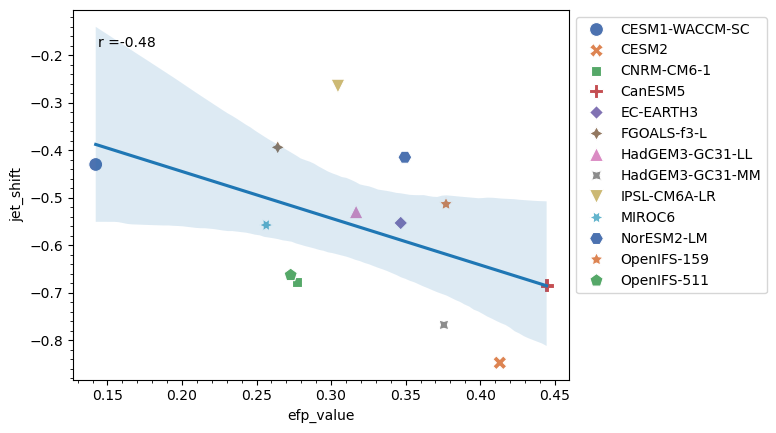

In [9]:
plt.figure()
# sns.regplot(data=jet_shifts, x='efp_value', y='jet_shift', scatter_kws={'color': 'white'}, line_kws={"color": "gray"})
scatter_plot = sns.scatterplot(
    x='efp_value', 
    y='jet_shift', 
    hue='model', 
    style='model', 
    data=jet_shifts, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='efp_value', 
    y='jet_shift', 
    data=jet_shifts, 
    scatter=False, 
    ax=scatter_plot
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=jet_shifts['efp_value'], y=jet_shifts['jet_shift'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

# plt.xlim([0,0.5])
# plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()